# Refitting a PLOG into a TROE
1. First step compute the value of the kinetic constant of the PLOG across the ranges of pressure and temperature desired.
2. Compute first guess values for the TROE kinetic constant formalism, we will need the three arrhenius parameters both for the High pressure and low pressure limits and the four parameters of the TROE fitting formalism.
3. Run the optimization.
4. Finally evaluate the refitted constant by visual comparison, different plots are provided down below.

Keep in mind that providing already a reasonable first guess is crucial for the success of the refitting.

In [1]:
import os
import sys
from functools import partial

# Matplotlib
import matplotlib.pyplot as plt

# JAX stuff
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, value_and_grad, jacfwd
import jax.numpy as jnp

# OPTAX
import optax
import optax.tree_utils as otu

# Internal modules
from diffPLOG2TROE.falloff import compute_falloff, kinetic_constant_falloff
from diffPLOG2TROE.pressure_logarithmic import compute_plog, kinetic_constant_plog
from diffPLOG2TROE.refitter import rmse_loss_function, run_lbfgs, print_info, compute_pressure_limits

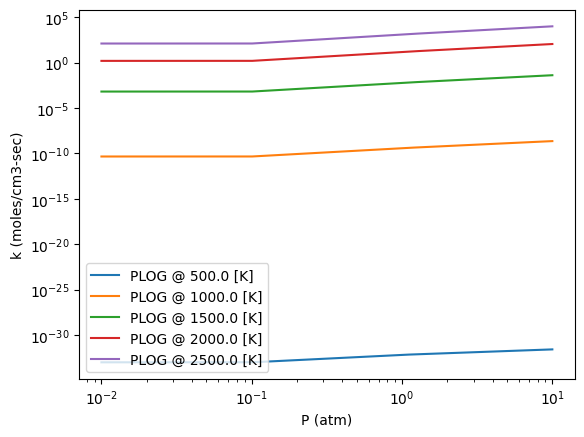

In [2]:
constant_plog = jnp.array([
    [1.00E-01, 7.23E+29, -5.32E+00, 110862.4],
    [1.00E+00, 3.50E+30, -5.22E+00, 111163.3],
    [1.00E+01, 1.98E+31, -5.16E+00, 111887.8],
    [1.00E+02, 2.69E+31, -4.92E+00, 112778.7],
], dtype=jnp.float64)

T = jnp.array([500, 1000, 1500, 2000, 2500], dtype=jnp.float64)  # Obv these are dummy values :)
P = jnp.logspace(-2, 1 , 300, dtype=jnp.float64)

for t in T:
    kc = compute_plog(constant_plog, jnp.array([t]), P)
    plt.plot(P, kc, "-", label=f"PLOG @ {t} [K]")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("P (atm)")
plt.ylabel("k (moles/cm3-sec)")
plt.legend()
plt.show()

In [3]:
T_range = jnp.logspace(2.5, 3.4, 50)
P_range = jnp.logspace(-1, 2, 50)

print(f"Temperature range -> {T_range[0]} - {T_range[-1]}")
print(f"Pressure range    -> {P_range[0]} - {P_range[-1]}")

k_plog = compute_plog(constant_plog, T_range, P_range)

pressure_limits_fg = compute_pressure_limits(constant_plog, T_range, P_range)

fg = jnp.array([
    jnp.log(pressure_limits_fg[3]), pressure_limits_fg[4], pressure_limits_fg[5]/1.987, # HPL
    jnp.log(pressure_limits_fg[0]), pressure_limits_fg[1], pressure_limits_fg[2]/1.987, # LPL
    10.0,    100.0,   1e+30, 1e+30
], dtype=jnp.float64)
data = (T_range, P_range, k_plog)

Temperature range -> 316.22776601683796 - 2511.88643150958
Pressure range    -> 0.1 - 100.0
 Computing first guesses for the LPL and HPL
  * Adjusted R2 for the LPL: 1.0
    - A: 7.2299875e+29, b: -5.32, Ea: 1.1086240e+05
  * Adjusted R2 for the HPL: 1.0
    - A: 2.6899955e+31, b: -4.92, Ea: 1.1277870e+05



In [4]:
%%time
#### OPTIMIZER PARAMETERS
MAXITER = 10000
TOL = 1e-10
### Linesearch algorithm parameters
MAXLS_STEPS = 50
### ADDITIONAL OPTIONS
PRINT_FREQ=20
### Optimizer setup
opt = optax.chain(
    print_info(frequency=PRINT_FREQ),
    optax.lbfgs(
        linesearch=optax.scale_by_zoom_linesearch(
            max_linesearch_steps=MAXLS_STEPS,
            verbose=False
        )
    )
)

fg_work = fg.copy()
data = (T_range, P_range, k_plog)
loss_function = rmse_loss_function
loss_function = partial(loss_function, data=data)
print(
    f"Initial value: {loss_function(fg_work):.5E}"
    f" Initial gradient norm: {otu.tree_l2_norm(jax.grad(loss_function)(fg_work)):.5E}"
)
final_params, _ = run_lbfgs(
    fg_work,
    loss_function,
    opt,
    max_iter=MAXITER,
    tol=TOL,
)

print(
    f"Final value: {loss_function(final_params):.5E}, "
    f"Final gradient norm: {otu.tree_l2_norm(jax.grad(loss_function)(final_params)):.5E}"
)

Initial value: 5.00000E+01 Initial gradient norm: 4.96902E-06
Iteration: 0, Value: 49.999999184513996, Gradient norm: 4.9690161593788686e-06
Iteration: 20, Value: 20.503198345014265, Gradient norm: 13.644070461700526
Iteration: 40, Value: 20.37119524228559, Gradient norm: 3.307702094614104
Iteration: 60, Value: 11.753115058432536, Gradient norm: 92.20818518273529
Iteration: 80, Value: 10.470751027716018, Gradient norm: 109.74060429764207
Iteration: 100, Value: 10.470331811514354, Gradient norm: 11.631030556695377
Iteration: 120, Value: 10.47015316195432, Gradient norm: 21.32033035780558
Iteration: 140, Value: 10.086579679397948, Gradient norm: 1430.7701207668158
Iteration: 160, Value: 10.025195087561364, Gradient norm: 59.70493653634305
Iteration: 180, Value: 10.02475781032543, Gradient norm: 10.84237414072345
Iteration: 200, Value: 10.022234398009676, Gradient norm: 8.619851352026435
Iteration: 220, Value: 10.022173989310616, Gradient norm: 1.5659982199678624
Iteration: 240, Value: 10

In [5]:
refitted_troe = (
    jnp.array([
        [jnp.exp(final_params[0]), final_params[1], final_params[2]*1.987, 0.000],  # HPL, the fourth term is dummy
        [jnp.exp(final_params[3]), final_params[4], final_params[5]*1.987, 0.000],  # LPL, the fourth term is dummy
        [final_params[6], final_params[7], final_params[8], final_params[9]],  # TROE parameters
    ], dtype=jnp.float64),
    1, # Lindemann -> 0, TROE -> 1, SRI -> 2
)

k_refitted = compute_falloff(refitted_troe, T_range, P_range)

print(refitted_troe)

(Array([[ 9.76467230e+28, -4.15111026e+00,  1.12668556e+05,
         0.00000000e+00],
       [ 1.97403842e+30, -3.63068600e+00,  1.09473684e+05,
         0.00000000e+00],
       [ 3.91246335e+00,  6.85577554e+01,  1.00000000e+30,
         1.00000000e+30]], dtype=float64), 1)


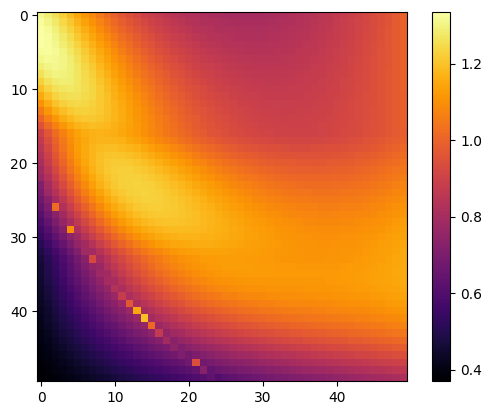

In [6]:
ratio = k_refitted / k_plog
fig, ax = plt.subplots()

c = ax.imshow(ratio, cmap='inferno', interpolation='nearest')
fig.colorbar(c, ax=ax)

plt.show()